In [1]:
import sys
sys.path.append('/home/harry/Documents/Oxford/Projects/DESEMU/reference/jax-cosmo/jax_cosmo-master/')

from classy import Class  # pylint: disable-msg=E0611
from ml_collections.config_dict import ConfigDict
import numpy as np 
import jax_cosmo as jc
import jax
from jax import grad, jit, vmap, jacfwd, hessian
import matplotlib.pylab as plt 


plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 20

In [2]:
def delete_module(class_module: Class):
    """Deletes the module to prevent memory overflow.
    Args:
        module (Class): A CLASS module
    """
    class_module.struct_cleanup()

    class_module.empty()

    del class_module

In [3]:
def get_config(experiment) -> ConfigDict:
    config = ConfigDict()
    config.logname = 'des-analysis'
    config.experiment = experiment
    
    # cosmological parameters
    config.cosmo = cosmo = ConfigDict()
    cosmo.names = ['sigma8', 'Omega_cdm', 'Omega_b', 'h', 'n_s']
    
    # neutrino settings
    config.neutrino = neutrino = ConfigDict()
    neutrino.N_ncdm = 1.0
    neutrino.deg_ncdm = 3.0
    neutrino.T_ncdm = 0.71611
    neutrino.N_ur = 0.00641
    neutrino.fixed_nm = 0.0 # 0.06
    
    # CLASS settings
    config.classy = classy = ConfigDict()
    classy.output = "mPk"
    classy.Omega_k = 0.0
    classy.k_max_pk = 50
    classy.k_min_pk = 1E-4
    classy.z_max_pk = 3.0
    classy.nk = 30
    classy.nz = 20

    # priors 
    config.priors = {
        'sigma8': {'distribution': 'uniform', 'loc': 0.6, 'scale': 0.4, 'fiducial': 0.8},
        'Omega_cdm': {'distribution': 'uniform', 'loc': 0.07, 'scale': 0.43, 'fiducial': 0.2},
        'Omega_b': {'distribution': 'uniform', 'loc': 0.03, 'scale': 0.04, 'fiducial': 0.04},
        'h': {'distribution': 'uniform', 'loc': 0.64, 'scale': 0.18, 'fiducial': 0.7},
        'n_s': {'distribution': 'uniform', 'loc': 0.87, 'scale': 0.2, 'fiducial': 1.0},
    }
    
    return config

In [4]:
def class_args(config: ConfigDict) -> dict:
    """Generates CLASS arguments to be passed to classy to compute the different quantities.
    Args:
        config (ConfigDict): A configuration file containing the parameters.
    Returns:
        dict: A dictionary to input to class
    """
    dictionary = dict()
    dictionary['output'] = config.classy.output
    dictionary['P_k_max_1/Mpc'] = config.classy.k_max_pk
    dictionary['z_max_pk'] = config.classy.z_max_pk
    dictionary['Omega_k'] = config.classy.Omega_k
    return dictionary

In [5]:
def neutrino_args(config: ConfigDict) -> dict:
    """Generates a dictionary for the neutrino settings.
    Args:
        config (ConfigDict): The main configuration file
    Returns:
        dict: A dictionary with the neutrino parameters.
    """
    dictionary = dict()
    dictionary['N_ncdm'] = config.neutrino.N_ncdm
    dictionary['deg_ncdm'] = config.neutrino.deg_ncdm
    dictionary['T_ncdm'] = config.neutrino.T_ncdm
    dictionary['N_ur'] = config.neutrino.N_ur
    dictionary['m_ncdm'] = config.neutrino.fixed_nm / config.neutrino.deg_ncdm
    return dictionary

In [6]:
def class_compute(config: ConfigDict, cosmology: dict) -> Class:
    """Pre-computes the quantities in CLASS.
    Args:
        config (ConfigDict): The main configuration file for running Class
        cosmology (dict): A dictionary with the cosmological parameters
    Returns:
        Class: A CLASS module
    """
    # generates the dictionaries to input to Class
    arg_class = class_args(config)
    arg_neutrino = neutrino_args(config)

    # Run Class
    class_module = Class()
    class_module.set(arg_class)
    class_module.set(arg_neutrino)
    class_module.set(cosmology)
    class_module.compute()

    return class_module

In [7]:
cfg = get_config('test')

In [8]:
cosmo = {'sigma8': 0.857570, 'Omega_cdm': 0.217284, 'Omega_b': 0.038872, 'h': 0.711447, 'n_s': 1.001982}
kgrid = np.geomspace(cfg.classy.k_min_pk, cfg.classy.k_max_pk, cfg.classy.nk)
zgrid = np.linspace(0.0, cfg.classy.z_max_pk, cfg.classy.nz)

In [9]:
def calculate_linear_pk_class(cosmology, cfg):
    """
    Calculate the linear matter power spectrum using CLASS
    """
    cmodule = class_compute(cfg, cosmology)
    
    # calculate the linear matter power spectrum
    kvalues = np.geomspace(cfg.classy.k_min_pk, cfg.classy.k_max_pk, cfg.classy.nk)
    class_pklin = []
    for kvalue in kvalues:
        class_pklin.append(cosmology['h']**3 * cmodule.pk_lin(cosmology['h']*kvalue, 0.0))
    class_pklin = np.array(class_pklin)
    delete_module(cmodule)
    return class_pklin

In [10]:
class_pklin = calculate_linear_pk_class(cosmo, cfg)

# JAX Cosmo

In [11]:
def calculate_linear_pk_jax(cosmology, kvalues):
    """
    Calculate the linear matter power spectrum using JAX cosmo
    """
    jax_pklin = []
    for kvalue in kvalues:
        jax_pklin.append(jc.power.linear_matter_power(cosmology, kvalue, a=1.0))
    return jax_pklin

pklin_jit = jit(calculate_linear_pk_jax)

In [12]:
jcosmo =  jc.Cosmology(sigma8=0.857570, Omega_c=0.217284, Omega_b=0.038872, h=0.711447, n_s=1.001982, 
                      w0=-1., Omega_k=0., wa=0.)

In [13]:
%%capture
jax_pklin = pklin_jit(jcosmo, kgrid) 

In [14]:
jax_pklin_np =  np.concatenate([jax_pklin]) 

# Comparison

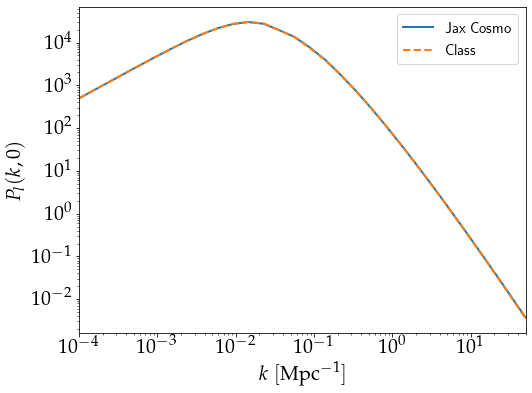

In [15]:
plt.figure(figsize = (8,6))
plt.loglog(kgrid, jax_pklin_np, lw = 2, label = 'Jax Cosmo')
plt.loglog(kgrid, class_pklin, lw = 2, linestyle = '--', label = 'Class')
plt.xlim(min(kgrid), max(kgrid))
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.ylabel(r'$P_{l}(k,0)$', fontsize = fontSize)
plt.xlabel(r'$k\;[\textrm{Mpc}^{-1}]$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.show()

# Decompose the linear matter power spectrum

In [16]:
def calculate_quantities(cosmology, cfg):
    """
    Calculate the linear matter power spectrum at redshift 0 and the growth factor as a function of redshift
    """
    kgrid = np.geomspace(cfg.classy.k_min_pk, cfg.classy.k_max_pk, cfg.classy.nk)
    zgrid = np.linspace(0.0, cfg.classy.z_max_pk, cfg.classy.nz)
    cmodule = class_compute(cfg, cosmology)
    class_pklin_z0 = []
    multiplying_factor = []
    # note that JAX cosmo computes everything with a factor h inside
    # which is why we are including the factor h here
    for kvalue in kgrid:
        class_pklin_z0.append(cosmology['h']**3 * cmodule.pk_lin(cosmology['h']*kvalue, 0))
    class_pklin_z0 = np.array(class_pklin_z0)
    
    for redshift in zgrid:
        factor = cosmology['h']**3 * cmodule.pk_lin(cosmology['h']*kgrid[0], redshift)
        multiplying_factor.append(factor / class_pklin_z0[0])
    multiplying_factor = np.array(multiplying_factor)
    delete_module(cmodule)
    return class_pklin_z0, multiplying_factor

In [17]:
def calculate_pklin_redshift(cosmology, cfg, redshift):
    """
    Calculate the linear matter power spectrum at any given redshift
    """
    kgrid = np.geomspace(cfg.classy.k_min_pk, cfg.classy.k_max_pk, cfg.classy.nk)
    cmodule = class_compute(cfg, cosmology)
    class_pklin = []
    for kvalue in kgrid:
        class_pklin.append(cosmology['h']**3 * cmodule.pk_lin(cosmology['h']*kvalue, redshift))
    class_pklin = np.array(class_pklin)
    delete_module(cmodule)
    return class_pklin

In [18]:
class_pklin_z0, multiplying_factor = calculate_quantities(cosmo, cfg)

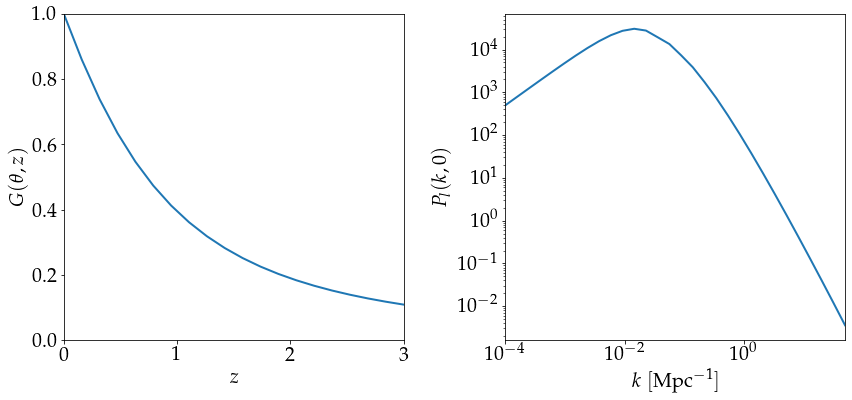

In [19]:
plt.figure(figsize = (14, 6))
plt.subplot(121)
plt.plot(zgrid, multiplying_factor, lw =2)
plt.ylabel(r'$G(\theta, z)$', fontsize = fontSize)
plt.xlabel(r'$z$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.ylim(0, 1)
plt.xlim(min(zgrid), max(zgrid))
plt.subplot(122)
plt.loglog(kgrid, class_pklin_z0, lw = 2)
plt.xlim(min(kgrid), max(kgrid))
plt.ylabel(r'$P_{l}(k,0)$', fontsize = fontSize)
plt.xlabel(r'$k\;[\textrm{Mpc}^{-1}]$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)
plt.show()

# Any Redshift

In [20]:
testredshift = 1.0

In [21]:
class_pklin_z = calculate_pklin_redshift(cosmo, cfg, redshift=testredshift)
class_pklin_prod = class_pklin_z0 * np.interp(testredshift, zgrid, multiplying_factor)

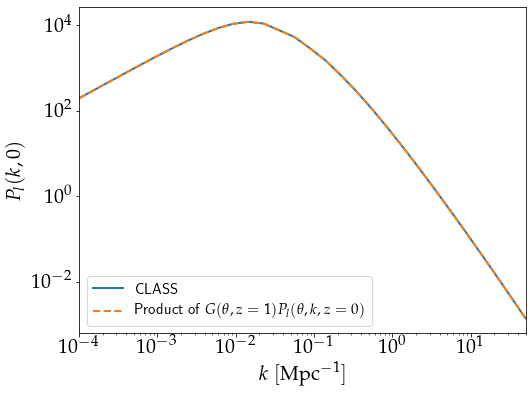

In [22]:
plt.figure(figsize=(8,6))
plt.loglog(kgrid, class_pklin_z, lw = 2, label = 'CLASS')
plt.loglog(kgrid, class_pklin_prod, lw = 2, linestyle = '--', label = r'Product of $G(\theta, z=1)P_{l}(\theta, k,z=0)$')
plt.xlim(min(kgrid), max(kgrid))
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.ylabel(r'$P_{l}(k,0)$', fontsize = fontSize)
plt.xlabel(r'$k\;[\textrm{Mpc}^{-1}]$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.show()

# Generate Training Set

In [23]:
import pandas as pd 
import scipy.stats 

In [24]:
lhs = pd.read_csv('data/lhs_1000.csv', index_col=0)

In [25]:
lhs.head()

,V1,V2,V3,V4,V5
1,0.409403,0.707022,0.458449,0.696310,0.386550
2,0.399692,0.428306,0.845907,0.282958,0.316863
3,0.264020,0.819791,0.263440,0.769574,0.183617
4,0.315184,0.867452,0.182386,0.270367,0.815225
5,0.754065,0.470705,0.166511,0.343403,0.658752


In [26]:
def generate_cosmo_priors(cfg):
    """Generates the entity of each parameter by using scipy.stats function.
    Args:
        dictionary (dict): A dictionary with the specifications of the prior.
    Returns:
        dict: the prior distribution of all parameters.
    """
    dictionary = dict()
    for name in cfg.cosmo.names:
        param = cfg.priors[name]
        specs = (param.loc, param.scale)
        dictionary[name] = getattr(scipy.stats, param.distribution)(*specs)
    return dictionary

In [27]:
def generate_inputs(lhs, priors):
    """
    Generate the input training points (the cosmologies). This essentially scales the latin hypercube samples 
    according to the prior range of the cosmological parameters. 
    """
    
    cosmologies = {}
    for i, p in enumerate(priors):
        cosmologies[p] = priors[p].ppf(lhs.iloc[:,i].values)
    cosmologies = pd.DataFrame(cosmologies)
    return cosmologies

In [28]:
cosmo_priors = generate_cosmo_priors(cfg)
cosmologies = generate_inputs(lhs, cosmo_priors)

In [29]:
cosmologies.head()

,sigma8,Omega_cdm,Omega_b,h,n_s
0,0.763761,0.374019,0.048338,0.765336,0.947310
1,0.759877,0.254172,0.063836,0.690932,0.933373
2,0.705608,0.422510,0.040538,0.778523,0.906723
3,0.726073,0.443004,0.037295,0.688666,1.033045
4,0.901626,0.272403,0.036660,0.701813,1.001750


In [33]:
def generate_outputs(cosmologies, cfg):
    ncosmo = 5 # cosmologies.shape[0]
    record_pklin = []
    record_gf = []
    for i in range(ncosmo):
        cosmology = dict(cosmologies.iloc[i])
        train_pklin, train_gf = calculate_quantities(cosmology, cfg)
        record_pklin.append(train_pklin)
        record_gf.append(train_gf)
    record_pklin = pd.DataFrame(record_pklin)
    record_gf = pd.DataFrame(record_gf)
    return record_pklin, record_gf

In [37]:
%%time # this is for 5 cosmological parameters - to run for 1000 cosmological parameters 
record_pklin, record_gf = generate_outputs(cosmologies, cfg)

CPU times: user 2min 9s, sys: 123 ms, total: 2min 9s
Wall time: 18.9 s


In [38]:
record_pklin

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,133.375806,204.717315,314.131760,481.713815,737.661150,1126.449773,1710.883303,2572.579917,3800.543079,5449.161901,...,117.607061,43.143684,15.068534,5.058288,1.644006,0.520286,0.161040,0.048916,0.014618,0.004304
1,495.437006,755.515549,1151.492705,1752.818094,2661.168951,4019.984051,6015.620842,8853.210834,12667.852339,17325.511061,...,79.128878,27.335181,9.087005,2.927222,0.918710,0.282126,0.085049,0.025229,0.007375,0.002124
2,109.003002,164.268810,247.498592,372.699337,560.577152,841.177085,1256.482385,1860.627044,2713.247357,3853.651671,...,105.529901,38.703828,13.464251,4.489006,1.445925,0.452744,0.138474,0.041524,0.012242,0.003555
3,51.636133,82.391737,131.431328,209.529705,333.581789,529.632790,836.526106,1308.405041,2011.477437,3003.810486,...,128.958227,49.610137,18.135405,6.362755,2.159068,0.712819,0.230041,0.072825,0.022677,0.006959
4,317.801656,499.855060,785.758135,1233.612898,1931.547926,3008.888538,4642.611441,7042.978795,10384.604609,14632.785256,...,135.348389,48.681728,16.814176,5.618928,1.827438,0.581054,0.181263,0.055626,0.016823,0.005017


In [39]:
record_gf

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1.0,0.822908,0.680981,0.568223,0.478647,0.407129,0.349581,0.302850,0.264539,0.232831,0.206348,0.184038,0.165090,0.148876,0.134904,0.122786,0.112212,0.102934,0.094751,0.087498
1,1.0,0.844816,0.714076,0.605824,0.516926,0.444065,0.384218,0.334832,0.293828,0.259551,0.230693,0.206225,0.185338,0.167389,0.151868,0.138368,0.126560,0.116178,0.107006,0.098866
2,1.0,0.815394,0.670027,0.556123,0.466599,0.395702,0.339006,0.293186,0.255759,0.224873,0.199134,0.177489,0.159132,0.143443,0.129936,0.118231,0.108024,0.099073,0.091181,0.084190
3,1.0,0.812338,0.665624,0.551305,0.461833,0.391203,0.334858,0.289405,0.252330,0.221767,0.196320,0.174936,0.156811,0.141326,0.128000,0.116454,0.106390,0.097565,0.089787,0.082897
4,1.0,0.846914,0.717338,0.609617,0.520861,0.447918,0.387874,0.338238,0.296970,0.262434,0.233332,0.208640,0.187548,0.169415,0.153729,0.140080,0.128139,0.117638,0.108358,0.100121
